# Implementing Workflow

Paper: https://www.tandfonline.com/doi/full/10.1080/2150704X.2016.1226522  
Workflow:  
![workflow](https://www.donike.net/wp-content/uploads/Bildschirmfoto-2021-09-26-um-17.00.31-768x222.jpg "Workflow")

T.o.C.:
0. Preparation
    0.1 Loading Data
    0.2 Defining thresholding and plot functions
1. Step 1:
    1.1 Thresholding
    1.2 Multi-Angular erosion
    1.3 Thresholding
2. Step 2:
    2.1 Rotation
    2.2 Multi-Scale Opening
    2.3 Addition of results
3. Step 3:
    3.1 Thresolding
    3.2 Minimim Bounding Boxes
4. Export Results
    4.1 Create Ship mask
    4.2 Write Ship Mask to Band


## 0. Preparation
### 0.1 Loading Data

In [1]:
import scipy.ndimage
import rasterio
import skimage.morphology
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import random
import matplotlib.pyplot as plt
from skimage import data
from skimage.filters import threshold_otsu
from numpy.ma import masked_array
import numpy.ma

from skimage.morphology import (erosion, dilation, opening, closing, white_tophat)
from skimage.morphology import black_tophat, skeletonize, convex_hull_image  # noqa
from skimage.morphology import disk
import numpy as np
import numpy.ma as ma

input_file_path = "data/s1_ships_clipped.tif"

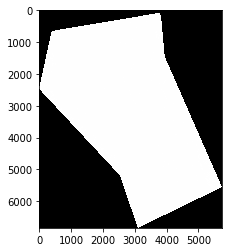

In [2]:
# Read image and raster
src = rasterio.open(input_file_path)
array = src.read(1)

plt.imshow(array,cmap="gray")

### 0.2 Defining thresholding and plot functions

In [3]:
def plot_comparison(original, filtered, filter_name):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 10), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')

In [4]:
def otsu(array,plot):
    image = array
    thresh = threshold_otsu(image)
    binary = image > thresh
    
    
    if plot:
        image_masked = np.multiply(image,binary)
        fig, axes = plt.subplots(ncols=3, figsize=(15, 4))
        ax = axes.ravel()
        ax[0] = plt.subplot(1, 3, 1)
        ax[1] = plt.subplot(1, 3, 2)
        ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

        ax[0].imshow(image, cmap=plt.cm.gray)
        ax[0].set_title('Original')
        ax[0].axis('off')

        ax[1].hist(image.ravel(), bins=256)
        ax[1].set_title('Histogram')
        ax[1].axvline(thresh, color='r')

        ax[2].imshow(binary, cmap=plt.cm.gray)
        ax[2].set_title('Thresholded Mask')
        ax[2].axis('off')

        plt.show()
    
    #return image values only for True pixels
    return(binary)

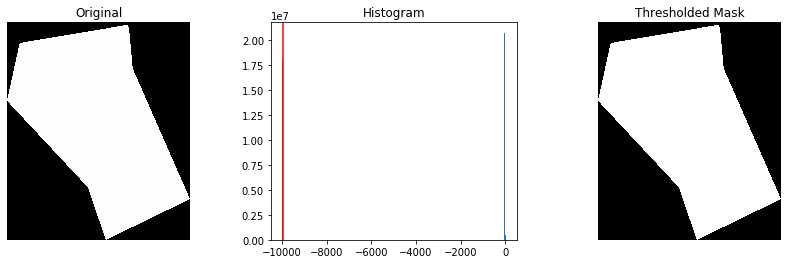

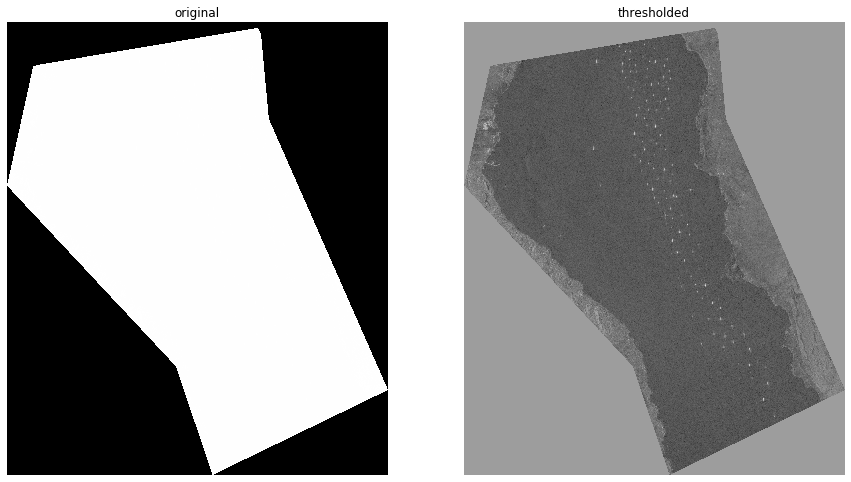

In [5]:
# test functions
plot_comparison(array, np.multiply(array,otsu(array,True)), "thresholded")

## 1. Step 1
### 1.1 Thresholding

In [6]:
mask_step_1 = otsu(array,False)
image_masked_step_1 = np.multiply(array,mask_step_1)

### 1.2 Multi-Angular Erosion

Instead of 5° steps, 4 steps of 45° are implemented. (Note: how to get 5° slope in np?)

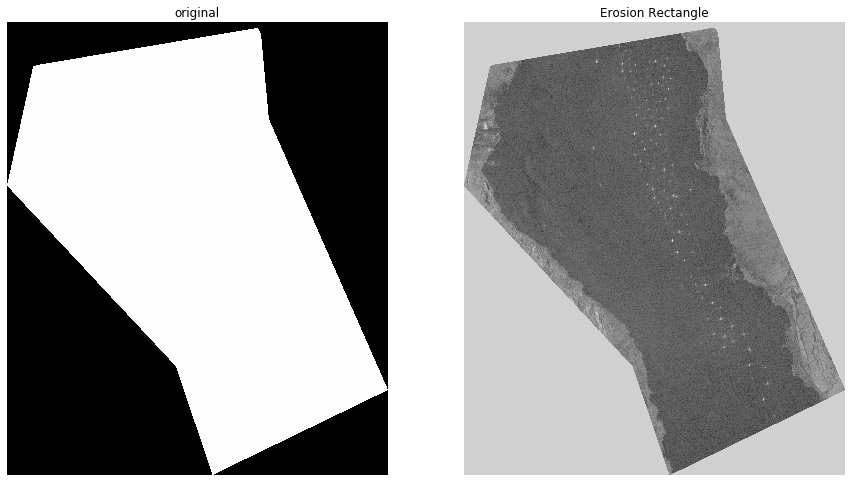

In [8]:
plot_comparison(array,erosion(image_masked_step_1,skimage.morphology.rectangle(10,5)),"Erosion Rectangle")

In [9]:
se_1 = np.array([[0,0,0,0,0,1,0,0,0,0],
                [0,0,0,0,0,1,0,0,0,0],
                [0,0,0,0,0,1,0,0,0,0],
                [0,0,0,0,0,1,0,0,0,0],
                [0,0,0,0,0,1,0,0,0,0],
                [0,0,0,0,0,1,0,0,0,0],
                [0,0,0,0,0,1,0,0,0,0],
                [0,0,0,0,0,1,0,0,0,0],
                [0,0,0,0,0,1,0,0,0,0],
                [0,0,0,0,0,1,0,0,0,0],
                ])

se_2 = np.array([[1,0,0,0,0,0,0,0,0,0],
                [0,1,0,0,0,0,0,0,0,0],
                [0,0,1,0,0,0,0,0,0,0],
                [0,0,0,1,0,0,0,0,0,0],
                [0,0,0,0,1,0,0,0,0,0],
                [0,0,0,0,0,1,0,0,0,0],
                [0,0,0,0,0,0,1,0,0,0],
                [0,0,0,0,0,0,0,1,0,0],
                [0,0,0,0,0,0,0,0,1,0],
                [0,0,0,0,0,0,0,0,0,1],
                ])

se_3 = np.array([[0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0],
                [1,1,1,1,1,1,1,1,1,1],
                [0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0],
                ])

se_4 = np.array([[0,0,0,0,0,0,0,0,0,1],
                [0,0,0,0,0,0,0,0,1,0],
                [0,0,0,0,0,0,0,1,0,0],
                [0,0,0,0,0,0,1,0,0,0],
                [0,0,0,0,0,1,0,0,0,0],
                [0,0,0,0,1,0,0,0,0,0],
                [0,0,0,1,0,0,0,0,0,0],
                [0,0,1,0,0,0,0,0,0,0],
                [0,1,0,0,0,0,0,0,0,0],
                [1,0,0,0,0,0,0,0,0,0],
                ])
se_multiangle = [se_1,se_2,se_3,se_4]

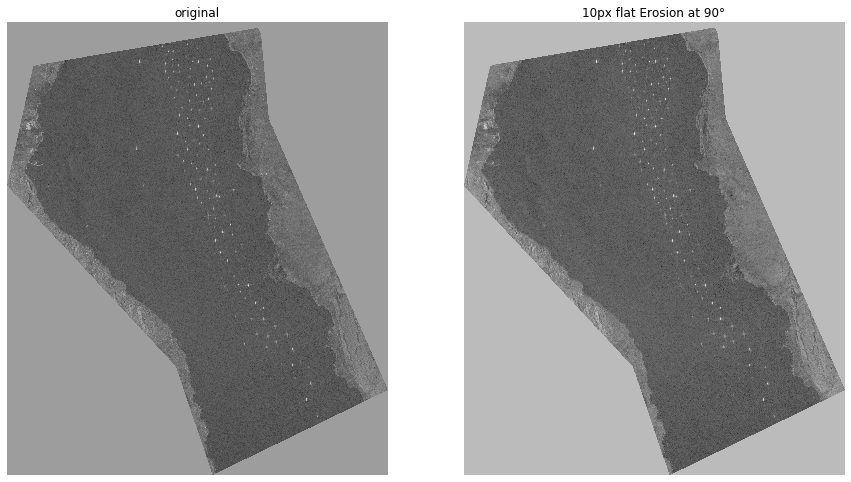

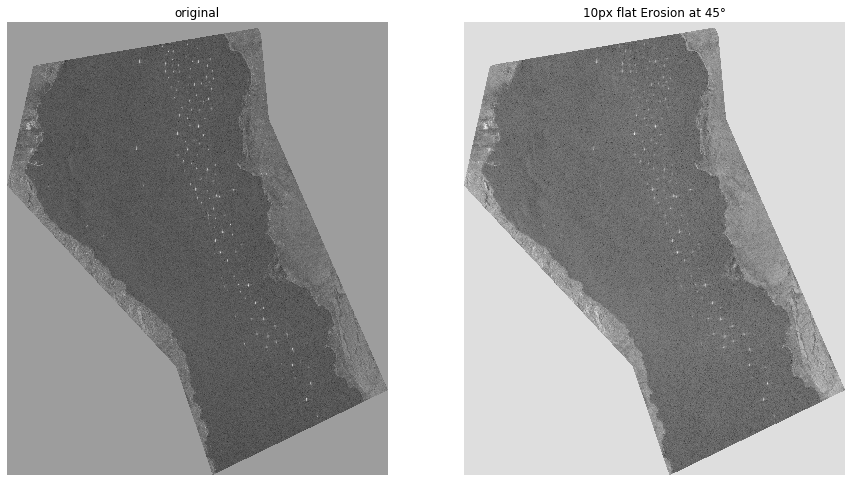

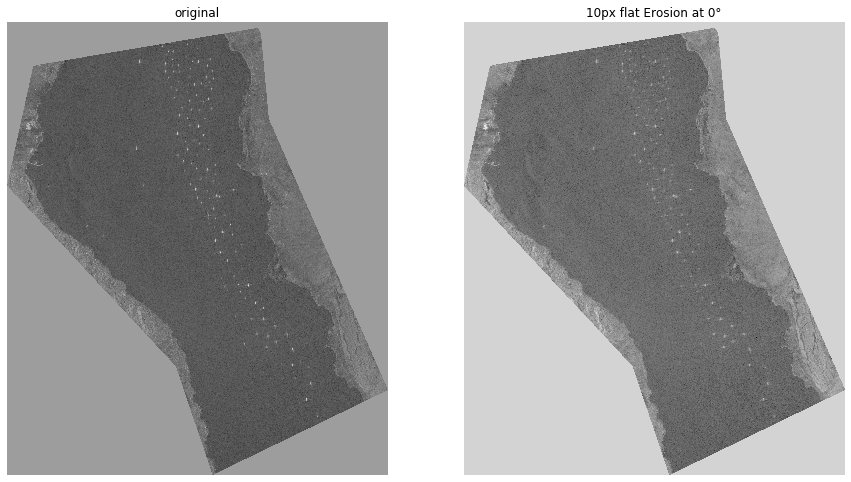

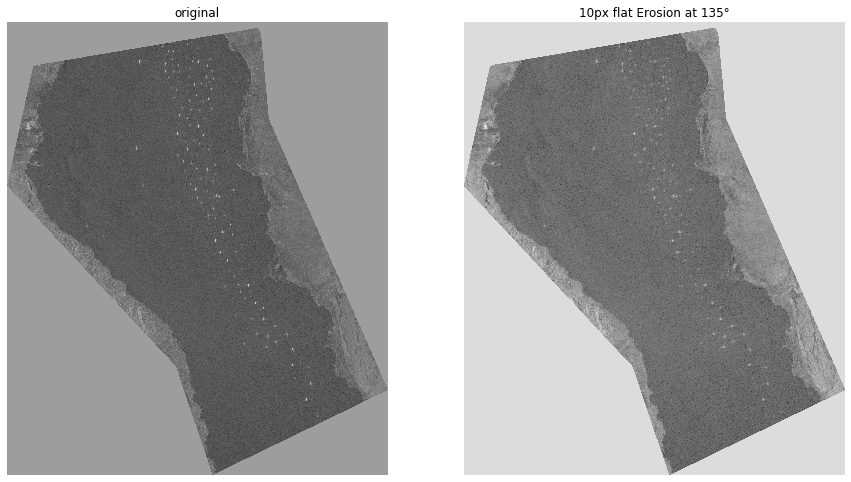

In [10]:
for se,degree in zip(se_multiangle,["90°","45°","0°","135°"]):
    plot_comparison(image_masked_step_1,erosion(image_masked_step_1,se),"10px flat Erosion at "+degree)

### 1.3 Thresholding

ToDo: New Thresholding

## 2.1 Rotation
Here, the authors rotate the matrix so that the main orientation of clusters is vertical. Since the ships in this image are already mainly vertical, there is no need to rotate it.

## 2.2 Multi-Scale (Horizontal and Vertical) Opening
Since the scale is "hard-coded" into this recreation of the workflow, the same scale as in the first step is used.

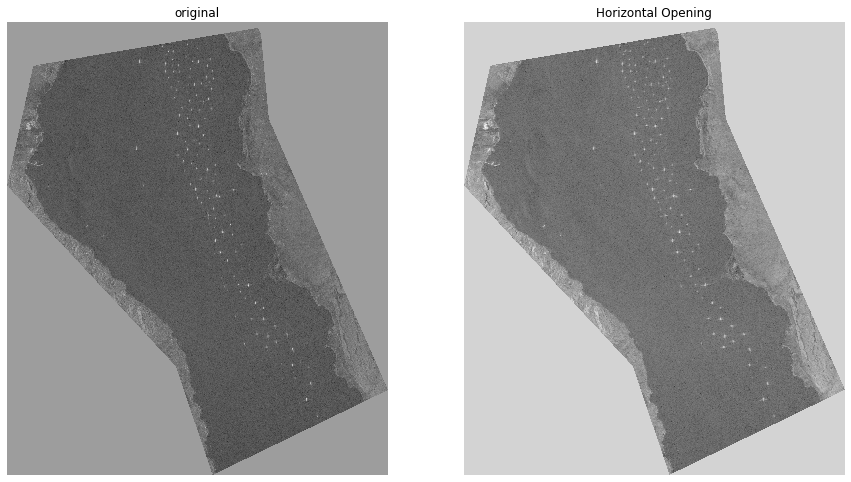

In [11]:
# Horizontal Opening
# erosion
pass_1 = erosion(image_masked_step_1,se_3)

# closing
horizontal_opening = dilation(pass_1,se_3)

# Result

plot_comparison(image_masked_step_1,horizontal_opening,"Horizontal Opening")


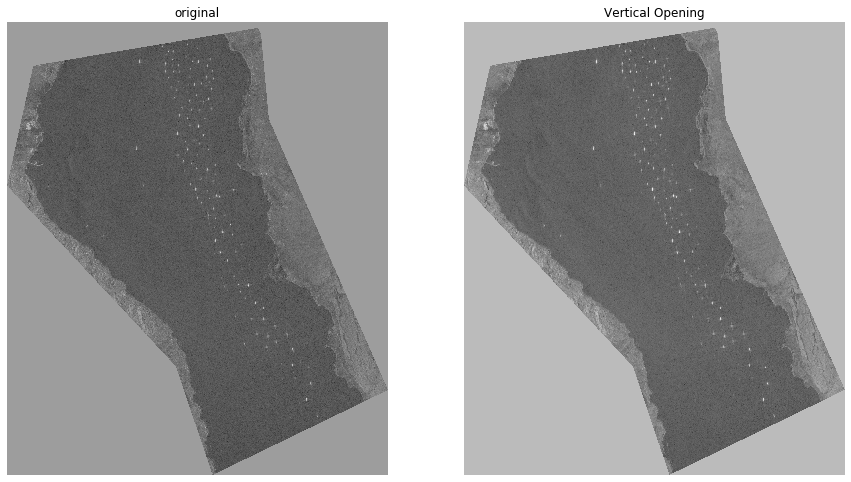

In [12]:
# Vertical Opening
# erosion
pass_1 = erosion(image_masked_step_1,se_1)

# closing
vertical_opening = dilation(pass_1,se_1)

# Result

plot_comparison(image_masked_step_1,vertical_opening,"Vertical Opening")


## 2.3 Addition of results

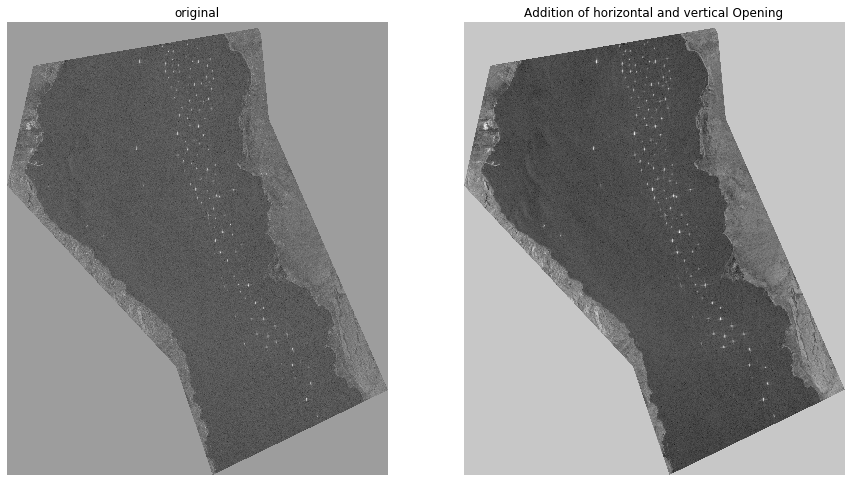

In [13]:
addition = np.add(horizontal_opening,vertical_opening)
plot_comparison(image_masked_step_1,addition,"Addition of horizontal and vertical Opening")

## Step 3
### 3.1 Thresholding



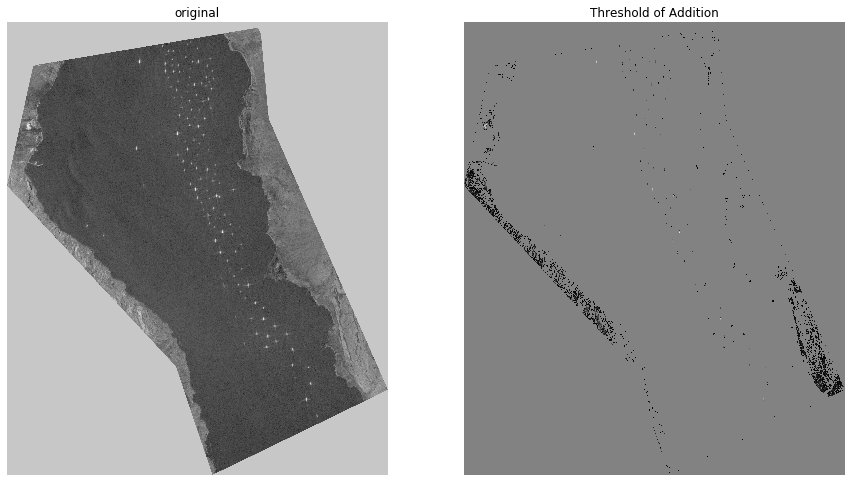

In [14]:
addition_thresholded = np.multiply(addition,otsu(addition,False))
plot_comparison(addition,addition_thresholded,"Threshold of Addition")

### 3.1 Remove last pixels?!

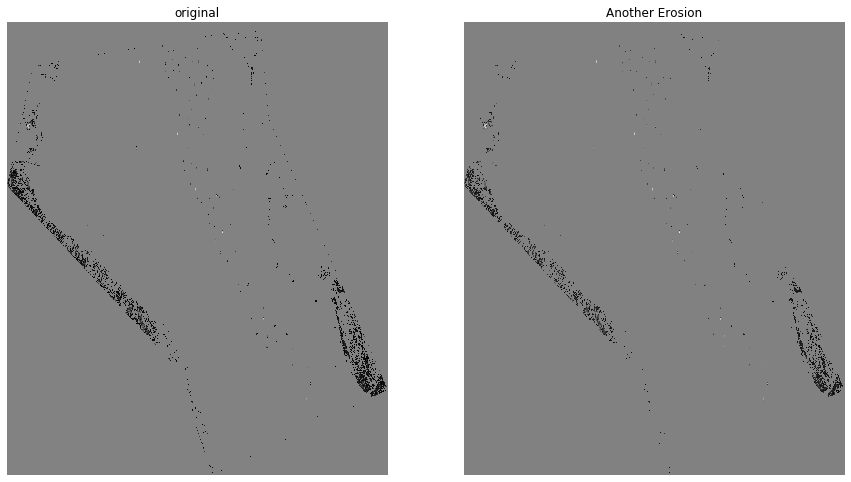

In [15]:
final = dilation(addition_thresholded,skimage.morphology.square(2))
plot_comparison(addition_thresholded,final,"Another Erosion")

### 3.2 Minimum Bounding Box

## 4.Export Results
### 4.1 Create Ship Mask

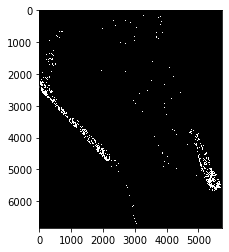

In [16]:
ship_mask = ma.getmask(ma.masked_where(addition_thresholded < 0, addition_thresholded))
ship_mask = ship_mask.astype(int)  
plt.imshow(ship_mask,cmap="gray")

### 4.2 Write Ship Mask to Band